# Noisy Trotter error in observable and expectation

## Observable evolution data

In [5]:
# common observables
from evolution import Evolve_ob, Evolve_state
import numpy as np
from quantum_simulation_recipe.trotter import pf, expH
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix

# set model, n, noise, time, number of steps
model = 'nnh'
n = 8
# n = 8
p = 5e-3
t, r = n, 100

H_list = []
if model == 'nnh':
    J, h, pbc = 2, 1, True
    model_par = {'Jz': J, 'hx': h, 'pbc': pbc}
    from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
    nnh = Nearest_Neighbour_1d(n, Jz=J, hx=h, pbc=pbc)
    H_list = [term.to_matrix() for term in nnh.ham_xyz]

dt = t/r

# set initial state
state_0 = np.zeros( (2**n, 2**n), dtype=complex)
state_0[0,0] = 1

# set time evolution unitary
U_dt = pf(H_list, dt, 1)
U_dt_exact = expH( sum(H_list), dt )

# set observables
str_ord_par = SparsePauliOp( 'X' + 'Z'*(n-2) + 'X', 1 ).to_matrix()
l_echo = state_0

avg_cor = np.zeros((2**n, 2**n), dtype=complex)
avg_mag = np.zeros((2**n, 2**n), dtype=complex)

for i in range(n-1):
    Z_i = SparsePauliOp( 'I'*i + 'Z' + 'I'*(n-i-1), 1 ).to_matrix()
    Z_j = SparsePauliOp( 'I'*(i+1) + 'Z' + 'I'*(n-i-2), 1 ).to_matrix()
    avg_cor += Z_i @ Z_j
    avg_mag += Z_i
avg_cor += SparsePauliOp( 'Z' + 'I'*(n-2) + 'Z', 1 ).to_matrix()
avg_mag += SparsePauliOp( 'I'*(n-1) + 'Z', 1 ).to_matrix()
avg_cor /= n
avg_mag /= n

# compute observable evolution
avg_cor_data = Evolve_ob(U_dt, U_dt_exact, r, avg_cor, p)
avg_mag_data = Evolve_ob(U_dt, U_dt_exact, r, avg_mag, p)
l_echo_data = Evolve_ob(U_dt, U_dt_exact, r, l_echo, p)
str_ord_par_data = Evolve_ob(U_dt, U_dt_exact, r, str_ord_par, p)

100%|██████████| 100/100 [12:05<00:00,  7.26s/it]


## Plot

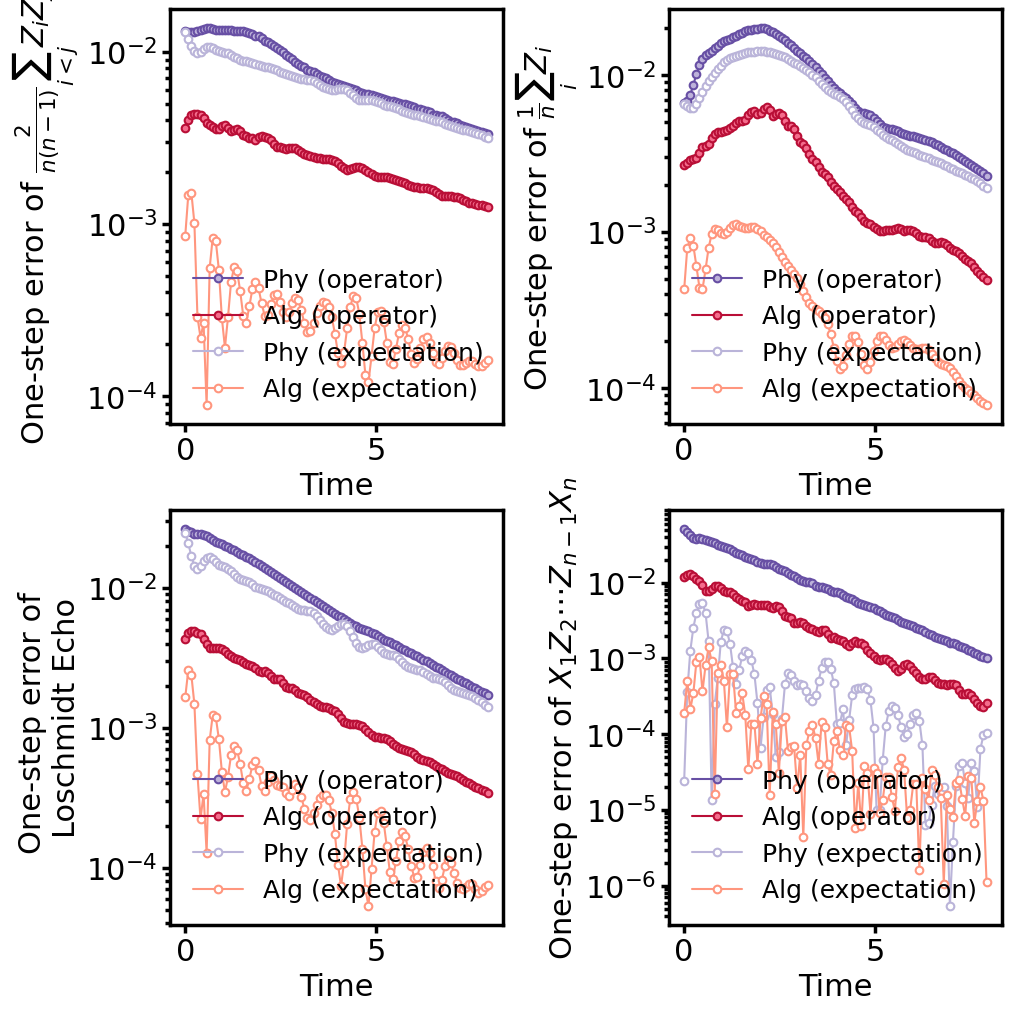

In [6]:
import matplotlib.pyplot as plt
from quantum_simulation_recipe.plot_config import *

# set plot format
good_color_cycle = ['#9467bdFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#ff7f0eFF', '#8c564bFF', '#e377c2FF', '#7f7f7fFF', '#bcbd22FF', '#17becfFF']
set_fontsize(medium=MEDIUM_SIZE+6, large=MEDIUM_SIZE+4, linewidth=2.5)
plt.rc('legend', fontsize=MEDIUM_SIZE) 
mpl.rcParams['font.family'] = 'sans-serif'  

mpl.rcParams['savefig.transparent'] = True
mpl.rcParams['axes.grid'] = False
mpl.rcParams['legend.frameon'] = False

# set color
gc = GradColors(10)
cm_phy, cm_alg = gc.purple, gc.red 
expval_color = good_color_cycle[-3]

# set x label (time)
t_list = np.arange(r)*dt

# set line width
dark_w, light_w = 7, 3

fig3, ax3 = plt.subplot_mosaic(
    '''
    AB
    CD
    ''', constrained_layout=True, figsize=(10, 10)
)

# plot values
plot_evo(ax3['A'], t_list, avg_cor_data.phy_err_list, '.-', c=cm_phy((dark_w)), label=r'Phy (operator)')
plot_evo(ax3['A'], t_list, avg_cor_data.alg_err_list, '.-', c=cm_alg(dark_w), label=r'Alg (operator)')
# plot_evo(ax3['A'], t_list, avg_cor_data.alg_err_list, '.-', c=good_color_cycle[0], label=r'alg_err')
# plot_evo(ax3['A'], t_list, avg_cor_data.phy_err_list, '.-', c=good_color_cycle[1], label=r'phy_err')
plot_evo(ax3['A'], t_list, avg_cor_data.state_phy_err_list, '.-', c=cm_phy((light_w)), label=r'Phy (expectation)')
plot_evo(ax3['A'], t_list, avg_cor_data.state_alg_err_list, '.-', c=cm_alg((light_w)), label=r'Alg (expectation)')

ax_set_text(ax3['A'], 'Time', r'One-step error of $\frac{2}{n(n-1)}\sum_{i<j}Z_iZ_j$', '', legend='lower left', log='y')

plot_evo(ax3['B'], t_list, avg_mag_data.phy_err_list, '.-', c=cm_phy(dark_w), label=r'Phy (operator)')
plot_evo(ax3['B'], t_list, avg_mag_data.alg_err_list, '.-', c=cm_alg(dark_w), label=r'Alg (operator)')
plot_evo(ax3['B'], t_list, avg_mag_data.state_phy_err_list, '.-', c=cm_phy((light_w)), label=r'Phy (expectation)')
plot_evo(ax3['B'], t_list, avg_mag_data.state_alg_err_list, '.-', c=cm_alg((light_w)), label=r'Alg (expectation)')
ax_set_text(ax3['B'], 'Time', r'One-step error of $\frac{1}{n}\sum_{i}Z_i$', '', legend='lower left', log='y')

plot_evo(ax3['C'], t_list, l_echo_data.phy_err_list, '.-', c=cm_phy(dark_w), label=r'Phy (operator)')
plot_evo(ax3['C'], t_list, l_echo_data.alg_err_list, '.-', c=cm_alg(dark_w), label=r'Alg (operator)')
plot_evo(ax3['C'], t_list, l_echo_data.state_phy_err_list, '.-', c=cm_phy((light_w)), label=r'Phy (expectation)')
plot_evo(ax3['C'], t_list, l_echo_data.state_alg_err_list, '.-', c=cm_alg((light_w)), label=r'Alg (expectation)')
ax_set_text(ax3['C'], 'Time', 'One-step error of \nLoschmidt Echo', '', legend='lower left', log='y')

plot_evo(ax3['D'], t_list, str_ord_par_data.phy_err_list, '.-', c=cm_phy(dark_w), label=r'Phy (operator)')
plot_evo(ax3['D'], t_list, str_ord_par_data.alg_err_list, '.-', c=cm_alg(dark_w), label=r'Alg (operator)')
plot_evo(ax3['D'], t_list, str_ord_par_data.state_phy_err_list, '.-', c=cm_phy((light_w)), label=r'Phy (expectation)')
plot_evo(ax3['D'], t_list, str_ord_par_data.state_alg_err_list, '.-', c=cm_alg((light_w)), label=r'Alg (expectation)')
ax_set_text(ax3['D'], 'Time', r'One-step error of $X_1Z_2\cdots Z_{n-1}X_n$', '', legend='lower left', log='y')

fig3.savefig(f'./figs/common_obs_state_n={n}.pdf')